In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [21]:
mcftr = pd.read_csv('data/mcftr.csv', encoding='windows-1251', sep=',')
gold = pd.read_excel('data/gold.xlsx')
snptr = pd.read_csv('data/snptr.csv', sep=',')

In [22]:
mcftr = mcftr[['Date', 'Close']].rename(columns={'Date': 'date', 'Close': 'price'})
gold = gold[['Дата', 'Значение']].rename(columns={'Дата': 'date', 'Значение': 'price'})
snptr = snptr[['Дата', 'Цена']].rename(columns={'Дата': 'date', 'Цена': 'price'})

mcftr['date'] = pd.to_datetime(mcftr['date'], format='%Y-%m-%d')
gold['date'] = pd.to_datetime(gold['date'], format='%Y-%m-%d')
snptr['date'] = pd.to_datetime(snptr['date'], format='%d.%m.%Y')

# filter dates to start from 2015-01-10
mcftr = mcftr[mcftr['date'] >= '2014-01-10']
gold = gold[gold['date'] >= '2014-01-10']
snptr = snptr[snptr['date'] >= '2014-01-10']

gold['price'] = pd.to_numeric(gold['price'])
mcftr['price'] = pd.to_numeric(mcftr['price'])
snptr['price'] = snptr['price'].apply(lambda x: x.replace('.', '').replace(',', '.'))
snptr['price'] = pd.to_numeric(snptr['price'])

In [23]:
mcftr['price_in_gold'] = mcftr['price'] / gold['price']
snptr['price_in_gold'] = snptr['price'] / gold['price']

In [24]:
gold.sort_values('date', inplace=True)

In [25]:
# Function to fill missing dates with most recent known price
def fill_missing_dates(df):
    df = df.sort_values('date')
    df = df.set_index('date')
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx)
    df['price'] = df['price'].ffill()
    return df.reset_index().rename(columns={'index': 'date'})

# Apply the function to each dataframe
mcftr = fill_missing_dates(mcftr)
gold = fill_missing_dates(gold)
snptr = fill_missing_dates(snptr)

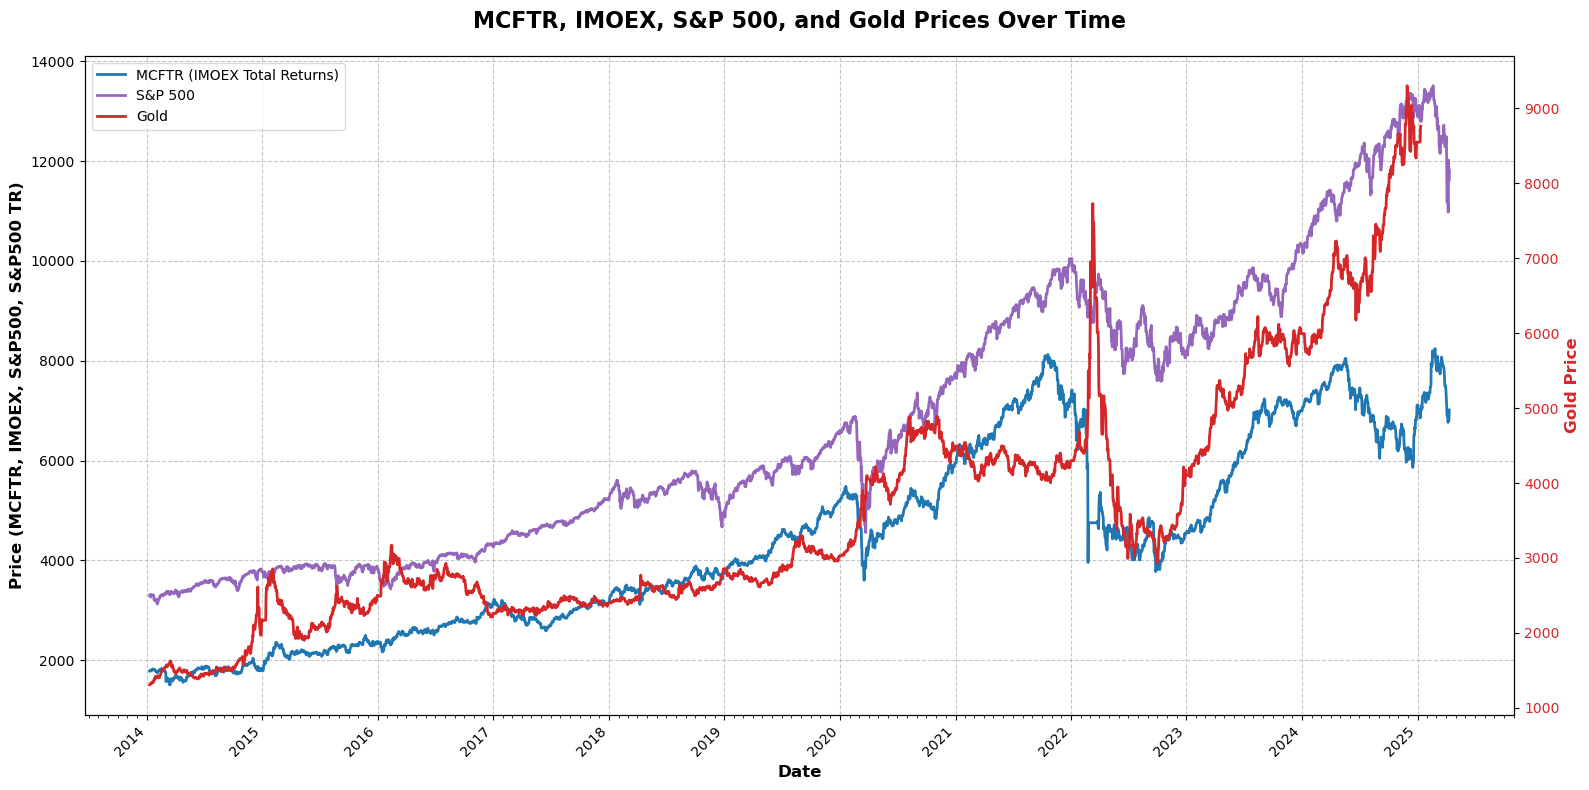

In [26]:
# Matplotlib graph
fig, ax1 = plt.subplots(figsize=(16, 8))


# Plot MCFTR, IMOEX, and S&P 500 on the left y-axis
ax1.plot(mcftr['date'], mcftr['price'], label='MCFTR (IMOEX Total Returns)', color='#1f77b4', linewidth=2)
ax1.plot(snptr['date'], snptr['price'], label='S&P 500', color='#9467bd', linewidth=2)

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price (MCFTR, IMOEX, S&P500, S&P500 TR)', color='black', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

# Plot Gold price on the right y-axis
ax2 = ax1.twinx()
ax2.plot(gold['date'], gold['price'], color='#d62728', label='Gold', linewidth=2)
ax2.set_ylabel('Gold Price', color='#d62728', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#d62728', labelsize=10)

# Improve x-axis date formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend with improved positioning and style
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, frameon=True, framealpha=0.7)

# Set title with improved font
plt.title('MCFTR, IMOEX, S&P 500, and Gold Prices Over Time', fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [27]:
merged_df = mcftr.copy().rename(columns={'price': 'mcftr_gold'})
merged_df['snptr_gold'] = snptr['price']
merged_df.drop(columns=['price_in_gold'], inplace=True)

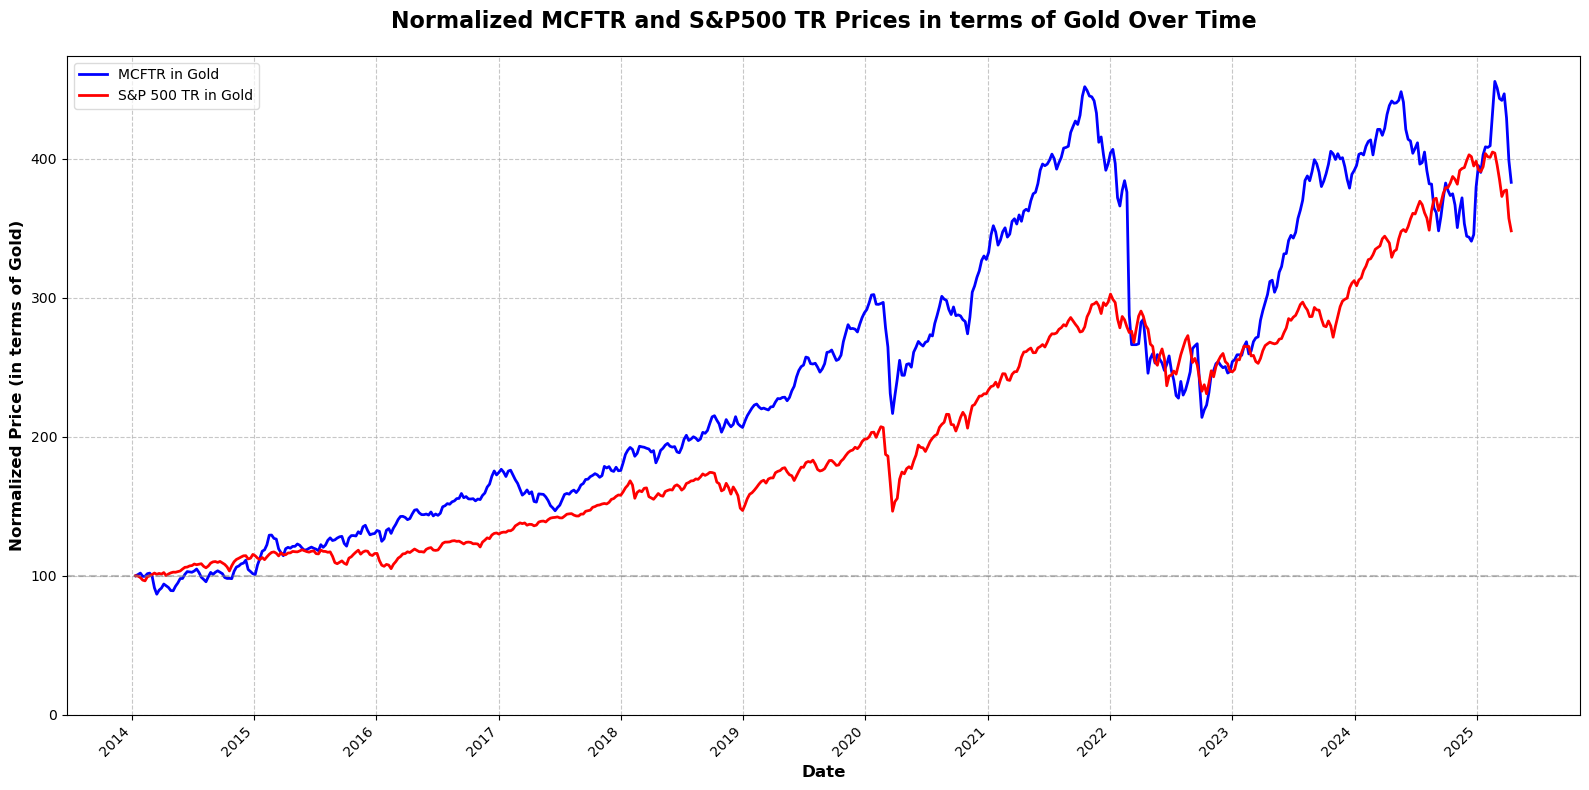

In [28]:
# Normalize prices (set first day as 100)
merged_df['mcftr_normalized'] = merged_df['mcftr_gold'] / merged_df['mcftr_gold'].iloc[0] * 100
merged_df['snptr_normalized'] = merged_df['snptr_gold'] / merged_df['snptr_gold'].iloc[0] * 100

# Convert date to datetime if it's not already
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate weekly mean prices for smoother visualization
weekly_df = merged_df.resample('W', on='date').mean().reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot normalized MCFTR and SNPTR in terms of gold
ax.plot(weekly_df['date'], weekly_df['mcftr_normalized'], 
        label='MCFTR in Gold', color='blue', linewidth=2)
ax.plot(weekly_df['date'], weekly_df['snptr_normalized'], 
        label='S&P 500 TR in Gold', color='red', linewidth=2)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Price (in terms of Gold)', color='black', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='black', labelsize=10)

# Improve x-axis date formatting
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend with improved positioning and style
ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.7)

# Set title with improved font
plt.title('Normalized MCFTR and S&P500 TR Prices in terms of Gold Over Time', 
          fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

# Add a horizontal line at y=100 to show the starting point
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
# calculate correlation coefficient
correlation_coef = weekly_df['mcftr_normalized'].corr(weekly_df['snptr_normalized'])
correlation_coef

0.9207390621226138